<h1 style="text-align:center !important; font-size:32px"> L'algorithme SwAV et l'apprentissage auto-supérvisé  appliqués à la classififcation des images non-labelisées des races de chien </h1>


# Introduction

L’étiquetage des images sera t'il bientôt du passé pour le deep learning? Jusqu’ici, le deep learning reposait sur la possibilité d’entraîner des algorithmes de catégorisation sur des données préalablement étiquetées. Le problème, c’est que cet étiquetage reste une tâche humaine et fastidieuse. Les nouveaux algorithmes d’apprentissage auto-supervisés n’ont plus besoin de cette étape. Pour se passer de la labellisation humaine des images, les algorithmes d’apprentissage auto-supervisé comme SwAV(Swapping Assignments between Views) vont analyser l’image après des distorsions comme une découpe, une rotation ou un filtre de couleur. L’algorithme classe ensuite les images dans des groupes dont les résultats des différentes distorsions se rapprochent le plus. Plus on utilise de distorsions plus la catégorisation devient précise.

L'Algorithme SwAV a été créé par une équipe Facebook AI Research, est décrit dans l’article scientifique [Unsupervised Learning of Visual Features by Contrasting Cluster Assignments](https://arxiv.org/abs/2006.09882)[1], est publiée en Juin 2020.

Nous allons appliquer l’algorithme ***SwAV*** sur la classification de races de chien avec des données non-labélisées pour pouvoir par la suite comparer les résultats obtenus et analyser la performance de l’algorithme, nous utiliserons un modèle pré-entrainé sur ces mêmes données d'un précédent projet (Classer des images à l’aide d’algorithmes de Deep Learning).

# <span style="color:#44546a; font-variant:small-caps;" id="section_1">Méthodes existantes de l'apprentissage auto-supervisé et leurs problémes</span>

Il existe deux familles distinctes de cadres d’apprentissage auto-supervisés pour l’apprentissage de la représentation visuelle :

1-***Approches basées sur le clustering*** qui extraient d’abord des features généralement l’aide  de ResNet50, puis appliquent une forme de clustering au-dessus de ces features pour regrouper ceux qui sont  similaires [6][7]. Le modèle sous-jacent est ensuite formé sur ces affectations de cluster (traitées comme des pseudo-étiquettes) de la même manière que la formation supervisée.

2-***Approches basées sur l’estimation contrastive du bruit*** où les modèles apprennent à maximiser l’accord entre des images  similaires tout en minimisant la même chose pour différentes images. Ces approches reposent sur  la perte contrastive et les transformations d’image fortes [1][2] [3][5][8]. 

Ces deux approches souffrent de plusieurs problèmes :

La premiére est généralement hors ligne, c’est-à-dire qu’elle nécessite une transmission en avant sur l’ensemble du jeu de données pour calculer les affectations de cluster. Pour les grands ensembles de données, cela devient rapidement coûteux sur le plan informatique.

La seconde fonctionne généralement en comparant différentes paires d’images, puis en calculant une perte contrastive. Ces paires sont généralement formées à l’aide de techniques d’augmentation de données puissantes telles que des cultures redimensionnées aléatoires, des distorsions de couleur et des retournements horizontaux. Contrairement à la premiére, cette méthode base le calcul des pertes sur des comparaisons par features, ce qui devient coûteux en calcul pour les grands ensembles de données.

En outre, afin d’avoir suffisamment d’échantillons négatifs (pour rendre le modèle d’apprentissage conscient des images sémantiquement différentes), ces méthodes maintiennent une grande banque de mémoire, une grande file d’attente de fonctionnalités précédemment calculées sur une taille de lot globale importante. Cela introduit également des dépenses de calcul. 

Motivé par ces problèmes, SwAV présente un pipeline de formation simplifié pour l’apprentissage de la représentation visuelle auto-supervisée. En outre, il introduit une politique d’augmentation multi-cultures qui nous aide à produire un nombre accru de vues à partir des images de formation. Cela améliore considérablement les performances.

# <span style="color:#44546a; font-variant:small-caps;" id="section_1">APercu sur La methode SwAV</span>

[Paper](https://arxiv.org/abs/2006.09882) | [Official PyTorch Implementation](https://github.com/facebookresearch/swav) | [Minimal TensorFlow Implementation](https://github.com/ayulockin/SwAV-TF)

## <span id="section_1_1">Contexte</span>
L'apprentissage non supervisé des représentations visuelles progresse à un rythme exceptionnellement rapide. La plupart des frameworks modernes connus dans ce domaine *(SimCLR, BYOL, MoCo (V2))*  utilisent un modèle auto-supervisé pré-entrainé avec un objectif d'apprentissage contrasté. La figure ci-dessous montre  leurs performances par rapport aux méthodes supervisées :

| ![swav_1](https://i.ibb.co/cNKjkLj/figure-1.png) | 
|:--:| 
| *Figure 1 :  Top-1 Accuracy des classificateurs linéaires entraînés avec les caractéristiques figées de différentes méthodes auto-supervisées par rapport aux méthodes entièrement supervisées.* |

De plus, lorsque les features apprises à l'aide de ces différentes méthodes d'auto-surveillance sont **affinées avec seulement 1 % et 10 % des données d'entraînement étiquetées**, elles montrent des performances extraordinaires.

| ![swav_2](https://i.ibb.co/80T1fYR/figure-2.png) | 
|:--:| 
| *Figure 2 :  T Performance de différents frameworks semi-supervisés et auto-supervisés sur le réglage fin avec très peu de données étiquetées (Source : SwAV [4]).* |


# <span style="color:#44546a; font-variant:small-caps;" id="section_2">Importations et configurations</span>

## <span id="section_2_1">Chargement des librairies externes</span>

## <span id="section_1_2"> La méthode SwAV </span>

| ![Swav_2](https://i.ibb.co/TtSW4Fd/figure-3.png) | 
|:--:| 
| *Figure 3 : Aperçu général de SwAV (Source : SwAV [4])* |


1- Plusieurs vues d’un lot d’images sont générées à l’aide du multi-recadrage et d’autres opérations d’augmentation appliquées séquentiellement comme la distorsion des couleurs, le retournement aléatoire et la mise à l’échelle de gris aléatoire .

2- Les vues sont passées par un backbone CNN (ResNet50) pour obtenir d’abord le vecteur d’iintegration (sortie de la dernière couche global Average Pooling).

3- Ce vecteur d’intégration (embedding vector) va ensuite à un réseau non linéaire peu profond. La sortie de ce réseau est le vecteur de projection noté par ***Z***.

4- ***Z*** est alimenté par une seule couche linéaire ; . Cette couche est la couche prototype et est désignée par ***C***. Cette couche cartographie Z à K vecteurs prototypes entraînables. La sortie de la couche est le produit de point entre Z et les prototypes. La matrice de " poids » associée de cette couche peut être considérée comme une banque prototype apprenante.

5- Enfin, une « partie » de la sortie de cette couche linéaire est utilisée pour l’affectation de cluster à l’aide de l’algorithme ***Sinkhorn Knopp***, et un problème de prédiction échangé est configuré. La sortie de Sinkhorn Knopp est indiquée par ***Q***.

Les auteurs de cet article se sont penchés sur une question :

> *Pouvons-nous apprendre une métrique significative qui reflète la similitude apparente entre les instances via un apprentissage discriminant pur ?*

Pour répondre à cela, ils ont conçu un nouvel algorithme d'apprentissage de caractéristiques non supervisé appelé instance-level discrimination. Ici, chaque image et ses transformations *(vues)* sont traitées comme deux instances distinctes. Chaque instance d'image est traitée comme une classe distincte. L'objectif est d'apprendre une intégration, un mapping $x$ *(image)* vers $v$ *(feature)* de telle sorte que les instances *(images)* sémantiquement similaires soient plus proches dans l'espace d'intégration.

| ![SWaV-anim.gif](https://jetnew.io/assets/img/swav/swav_gif.gif) | 
|:--:| 
| *Figure 3 : Representation of SwAV method* |


# Importations et configurations 

## Chargement des librairies externes

In [1]:
!git clone https://github.com/ayulockin/SwAV-TF
    
import sys
sys.path.append('SwAV-TF/utils')

Cloning into 'SwAV-TF'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 301 (delta 62), reused 11 (delta 7), pack-reused 198
Receiving objects: 100% (301/301), 18.73 MiB | 23.82 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
# Import SwAV methods
import multicrop_dataset
import architecture

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import time
import os
import gc

from itertools import groupby
from tqdm import tqdm

In [4]:
tf.random.set_seed(666)
np.random.seed(666) 

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## <span id="section_2_2">Création des Datasets de Train et Test</span>
Ici, nous allons charger le jeu de données extrait du dataset Stanford Dogs, composé  des **10 races** de chien préférées chez les Français en mode **non-supervisé**.

In [6]:
# Train Dataset
TRAIN_PATH = "../input/data-no-label/Stanford_Dogs_Dataset_Unlabeled/train/"
train_images = os.listdir(TRAIN_PATH)
train_df = pd.DataFrame(columns=["image_id", "image"])
train_df["image_id"] = [file.split(".")[0] for file in train_images]
train_df["image"] = train_images
train_df.head()

image_id                image
0   n02100735_6132   n02100735_6132.jpg
1  n02088364_17167  n02088364_17167.jpg
2   n02100735_5265   n02100735_5265.jpg
3   n02088364_7247   n02088364_7247.jpg
4   n02085620_2887   n02085620_2887.jpg

In [7]:
# Test Dataset
TEST_PATH = "../input/data-no-label/Stanford_Dogs_Dataset_Unlabeled/test/"
test_images = os.listdir(TEST_PATH)
test_df = pd.DataFrame(columns=["image_id", "image"])
test_df["image_id"] = [file.split(".")[0] for file in test_images]
test_df["image"] = test_images
test_df = test_df.iloc[:480]
test_df.head()

image_id               image
0  n02100735_7450  n02100735_7450.jpg
1  n02102318_8784  n02102318_8784.jpg
2  n02085620_2973  n02085620_2973.jpg
3   n02102318_239   n02102318_239.jpg
4  n02102318_5075  n02102318_5075.jpg

In [8]:
print(f"Nombre d'enregistrements de Train : {len(train_df)}")
print(f"Nombre d'enregistrements de Test : {len(test_df)}")

Nombre d'enregistrements de Train : 1151
Nombre d'enregistrements de Test : 480


In [9]:
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def parse_data(df_dict):
    img = tf.io.read_file(TRAIN_PATH+df_dict['image'])
    img = tf.image.decode_jpeg(img, channels=3)
    image = {'image': img}
    return image

# Create Tensorflow Dataset
vizloader = tf.data.Dataset.from_tensor_slices(dict(train_df))

vizloader = (
    vizloader
    .map(parse_data, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

### Visualisation d'exemples d'images de Train

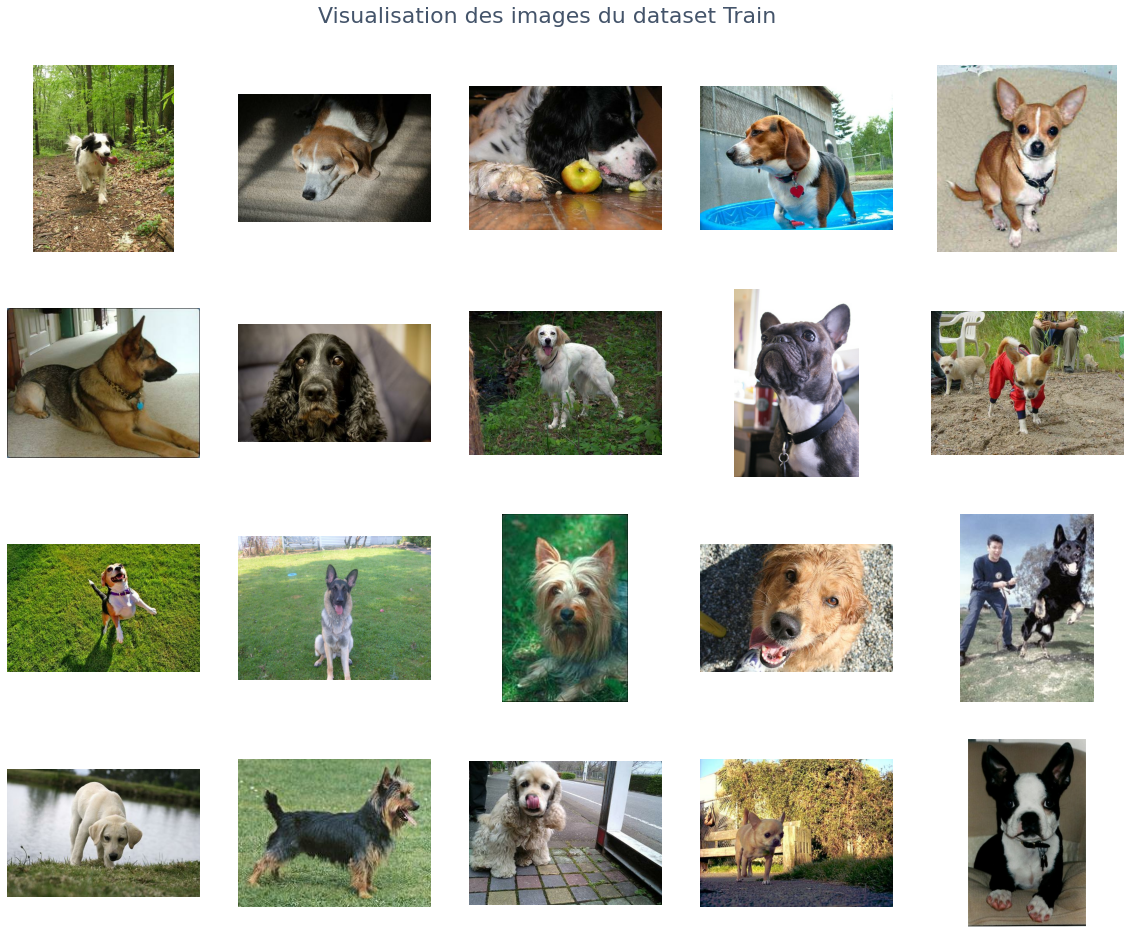

In [10]:
#Visualization
def show_batch(image_batch):
    plt.figure(figsize=(20,20))
    plt.suptitle("Visualisation des images du dataset Train", 
             fontsize=22, color="#44546a", y=0.92)
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')
    
image_batch = []
for img in vizloader.take(20):
    image_batch.append(img['image'])

show_batch(image_batch)

# <span style="color:#44546a; font-variant:small-caps;" id="section_3">Preprocessing et Data augmentation : Multi-crop</span>

Le type de preprocessesing et de data augmentation a utiliser est très important pour que l'algorithme donne les résultats attendus. Il s'agit de la stratégie Multi-Crop :

| ![data-augmentation](https://i.ibb.co/RBGqZmk/figure-4.png) | 
|:--:| 
| *Figure 4 : Multi-crop = l'image $x_n$ est transformée en $V+2$ vues : deux vues globales et $V$ vues de petite résolution .* |

- Nous obtenons deux vues différentes à partir d'une image en effectuant des **recadrages de tailles et de proportions aléatoires**. pour cela, la méthode ***RandomResizedCrop*** du module `torchvision.transforms` de PyTorch est utilisée avec les paramètres de mise à l'échelle suivants : `s=(0.14, 1)`. 

- Ces deux vues sont redimensionnées en pleine résolution à 224 x 224 pixels.

- Création de $V$ vues supplémentaires en recadrant de petites parties dans l'image. Pour ce faire, nous utilisons les paramètres RandomResizedCrop suivants : `s=(0.5,0,14)`. Nous redimensionnons les recadrages résultants à une résolution de 96 x 96. 

- Enfin, nous appliquons au hasard des retournements horizontaux, distorsion des couleurs et flou gaussien à chaque recadrage résultant.

In [11]:
# Configs
BS = 16
# Image sizes used to train the model.
SIZE_CROPS = [224, 96]
# Number of different augmentations of the same image
NUM_CROPS = [2, 2]
# Parameters for Random Resize Crop.
MIN_SCALE = [0.5, 0.14] 
MAX_SCALE = [1., 0.5]

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [12]:
# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(
    vizloader,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

Nous avons décidé d’opter pour 2 cultures hautes res (224x224) et 2 cultures basse res (96x96) totalisant quatres vues. Pour obtenir ces 4 vues à la volée pendant l’entraînement, nous utilisons .tf.data.Dataset.zip

In [13]:
# Prepare the final data loader
# Zipping 
trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

# Final trainloader
trainloaders_zipped = (
    trainloaders_zipped
    .batch(BS)
    .prefetch(AUTO)
)

im1, im2, im3, im4 = next(iter(trainloaders_zipped))
print(im1.shape, im2.shape, im3.shape, im4.shape)

(16, 224, 224, 3) (16, 224, 224, 3) (16, 96, 96, 3) (16, 96, 96, 3)


On remarque donc ici que nos différents crops sont bien créés avec les tailles désirées. Nous pouvons à présent **visualiser quelques résultats** :

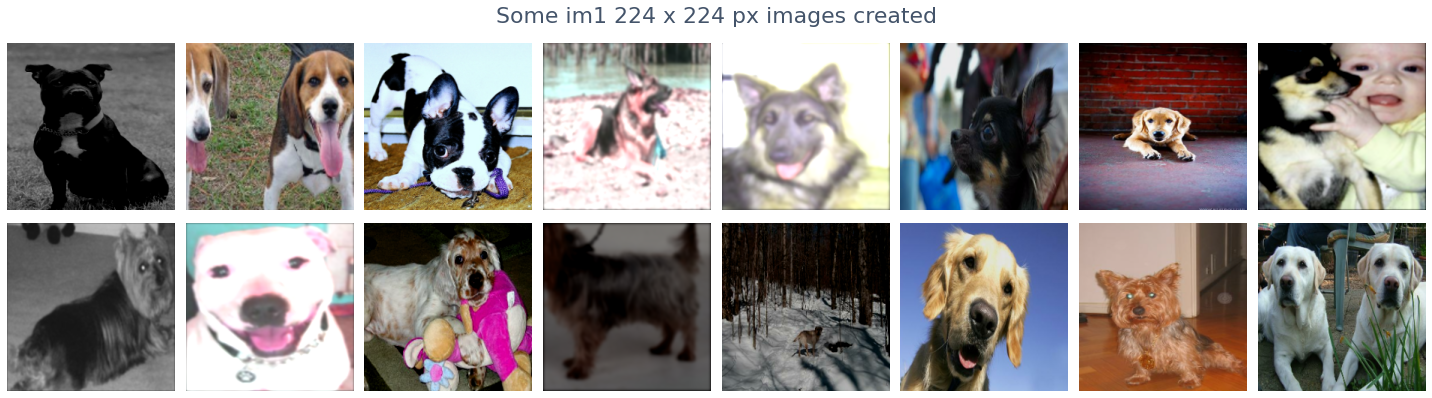

In [14]:
plt.figure(figsize=(20, 6))
for n in range(16):
    ax = plt.subplot(2, 8, n+1)
    plt.imshow(im1[n])
    plt.axis('off')
plt.suptitle("Some im1 224 x 224 px images created", y=0.95,
             fontsize=22, color="#44546a")
plt.tight_layout()
plt.show()

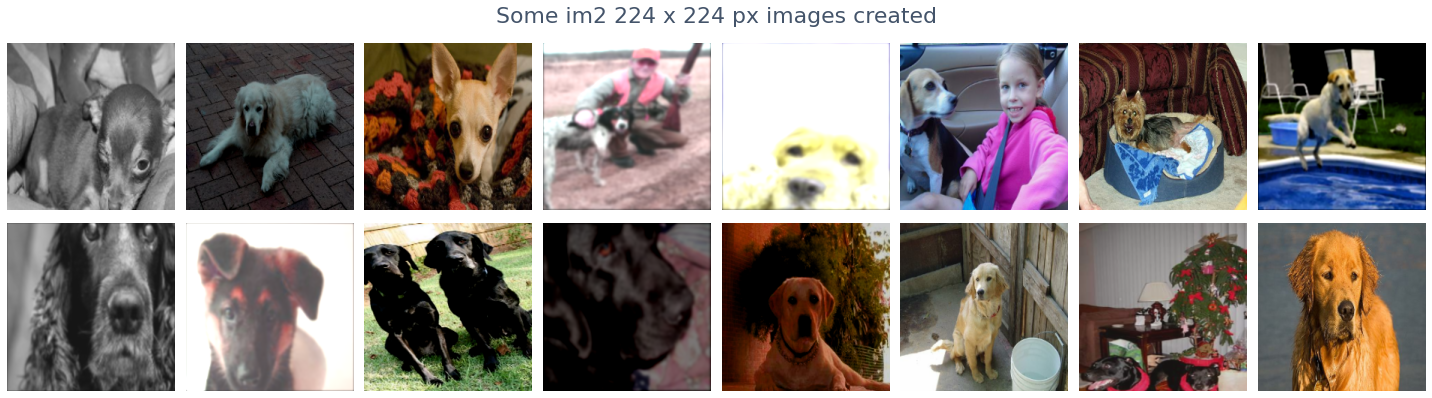

In [15]:
plt.figure(figsize=(20, 6))
for n in range(16):
    ax = plt.subplot(2, 8, n+1)
    plt.imshow(im2[n])
    plt.axis('off')
plt.suptitle("Some im2 224 x 224 px images created", y=0.95,
             fontsize=22, color="#44546a")
plt.tight_layout()
plt.show()

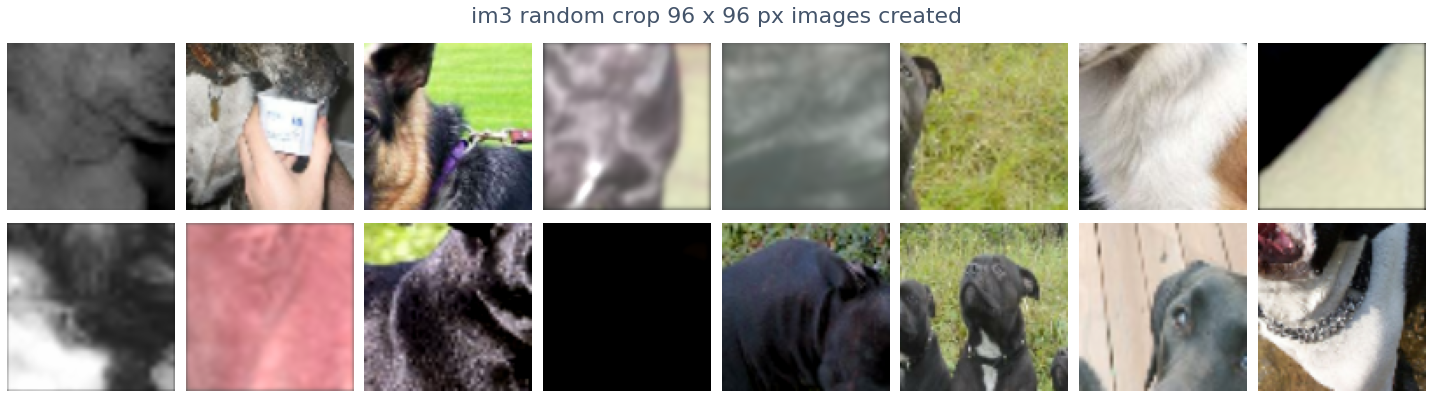

In [16]:
plt.figure(figsize=(20, 6))
for n in range(16):
    ax = plt.subplot(2, 8, n+1)
    plt.imshow(im3[n])
    plt.axis('off')
    plt.suptitle("im3 random crop 96 x 96 px images created", y=0.95,
                 fontsize=22, color="#44546a")
plt.tight_layout()
plt.show()

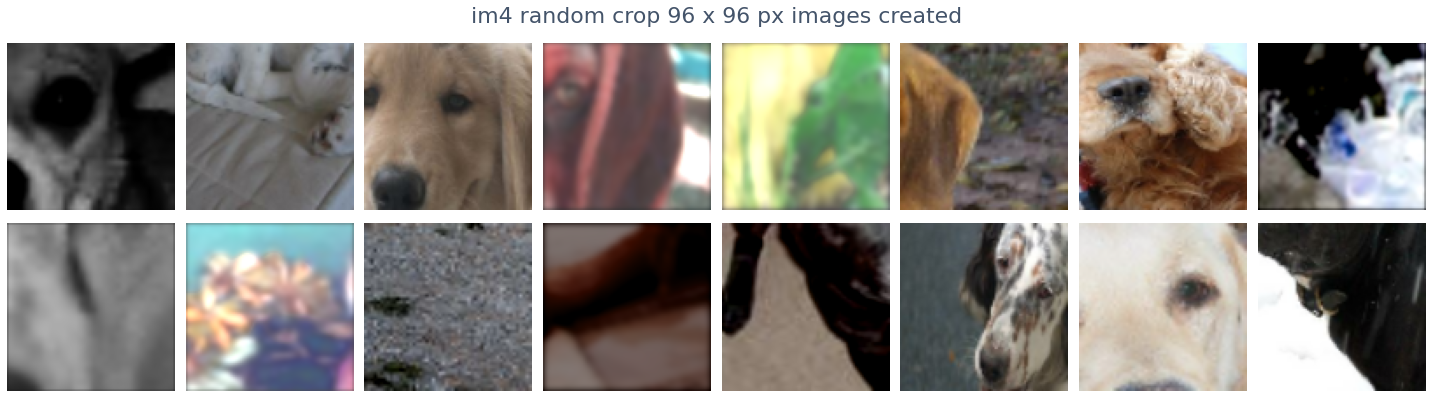

In [17]:
plt.figure(figsize=(20, 6))
for n in range(16):
    ax = plt.subplot(2, 8, n+1)
    plt.imshow(im4[n])
    plt.axis('off')
    plt.suptitle("im4 random crop 96 x 96 px images created", y=0.95,
                 fontsize=22, color="#44546a")
plt.tight_layout()
plt.show()

# <span style="color:#44546a; font-variant:small-caps;" id="section_4">Architecture du modèle ResNet - SwAV</span>

Dans ce papier, le modèle de base utilisé est un ResNet50. 2 approches sont étudiées :

- Une classification linéaire sur les features détectées,
- et une approche semi-supervisée par fine-tuning en utilisant quelques labels (de 1% à 10% de données labélisées).

## <span id="section_4_1">Chargement des modèles de base</span>

In [18]:
tf.keras.backend.clear_session()
feature_backbone = architecture.get_resnet_backbone()
feature_backbone.summary()

del feature_backbone
_ = gc.collect()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
tf.keras.backend.clear_session()
projection_prototype = architecture.get_projection_prototype(2048, 128, 256)
projection_prototype.summary()

del projection_prototype
_ = gc.collect()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
tf.math.l2_normalize (TFOpLa (None, 128)               0         
_________________________________________________________________
prototype (Dense)            (None, 256)               32768 

## <span id="section_4_2">Sinkhorn Knopp pour l'affectation de cluster</span>

Affectation de cluster en ligne et configuration du problème de swapped prediction. L'idée de prédiction permutée *(swapped prediction)* est que **le code d'une vue d'une image est prédit à partir de la représentation d'une autre vue de la même image**.

| ![data-augmentation](http://www.mf-data-science.fr/images/projects/Swav-swapped-Prediction.png) | 
|:--:| 
| *Figure 5 : Affectation de cluster suivie d'une prédiction permutée.* |

In [20]:
def sinkhorn(sample_prototype_batch):
    Q = tf.transpose(tf.exp(sample_prototype_batch/0.01))
    Q /= tf.keras.backend.sum(Q)
    K, B = Q.shape

    u = tf.zeros_like(K, dtype=tf.float32)
    r = tf.ones_like(K, dtype=tf.float32) / K
    c = tf.ones_like(B, dtype=tf.float32) / B

    for _ in range(3):
        u = tf.keras.backend.sum(Q, axis=1)
        Q *= tf.expand_dims((r / u), axis=1)
        Q *= tf.expand_dims(c / tf.keras.backend.sum(Q, axis=0), 0)

    final_quantity = Q / tf.keras.backend.sum(Q, axis=0, keepdims=True)
    final_quantity = tf.transpose(final_quantity)

    return final_quantity

## <span id="section_4_3">Les étapes d'entrainement du modèle</span>

Les étapes suivantes sont calquées sur l'implémentation PyTorch liée au papier : [ https://github.com/facebookresearch/swav/blob/master/main_swav.py]( https://github.com/facebookresearch/swav/blob/master/main_swav.py)

In [21]:
# @tf.function
def train_step(input_views, feature_backbone, projection_prototype, 
               optimizer, crops_for_assign, temperature):
    # ============ retrieve input data ... ============
    im1, im2, im3, im4 = input_views 
    inputs = [im1, im2, im3, im4]
    batch_size = inputs[0].shape[0]

    # ============ create crop entries with same shape ... ============
    crop_sizes = [inp.shape[1] for inp in inputs] # list of crop size of views
    unique_consecutive_count = [len([elem for elem in g]) for _, g in groupby(crop_sizes)] # equivalent to torch.unique_consecutive
    idx_crops = tf.cumsum(unique_consecutive_count)
    
    # ============ multi-res forward passes ... ============
    start_idx = 0
    with tf.GradientTape() as tape:
        for end_idx in idx_crops:
            concat_input = tf.stop_gradient(tf.concat(inputs[start_idx:end_idx], axis=0))
            _embedding = feature_backbone(concat_input) # get embedding of same dim views together
            if start_idx == 0:
                embeddings = _embedding # for first iter
            else:
                embeddings = tf.concat((embeddings, _embedding), axis=0) # concat all the embeddings from all the views
            start_idx = end_idx
        
        projection, prototype = projection_prototype(embeddings) # get normalized projection and prototype
        projection = tf.stop_gradient(projection)

        # ============ swav loss ... ============
        # https://github.com/facebookresearch/swav/issues/19
        loss = 0
        for i, crop_id in enumerate(crops_for_assign): # crops_for_assign = [0,1]
            with tape.stop_recording():
                out = prototype[batch_size * crop_id: batch_size * (crop_id + 1)]
                
                # get assignments
                q = sinkhorn(out) # sinkhorn is used for cluster assignment
            
            # cluster assignment prediction
            subloss = 0
            for v in np.delete(np.arange(np.sum(NUM_CROPS)), crop_id): # (for rest of the portions compute p and take cross entropy with q)
                p = tf.nn.softmax(prototype[batch_size * v: batch_size * (v + 1)] / temperature) 
                subloss -= tf.math.reduce_mean(tf.math.reduce_sum(q * tf.math.log(p), axis=1))
            loss += subloss / tf.cast((tf.reduce_sum(NUM_CROPS) - 1), tf.float32)
        
        loss /= len(crops_for_assign)

    # ============ backprop ... ============
    variables = feature_backbone.trainable_variables + projection_prototype.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [22]:
# ============ Train loop ============
def train_swav(feature_backbone, 
               projection_prototype, 
               dataloader, 
               optimizer, 
               crops_for_assign,
               temperature, 
               epochs=50):
  
    step_wise_loss = []
    epoch_wise_loss = []
    
    for epoch in range(epochs):
        w = projection_prototype.get_layer('prototype').get_weights()
        w = tf.transpose(w)
        w = tf.math.l2_normalize(w, axis=1)
        projection_prototype.get_layer('prototype').set_weights(tf.transpose(w))

        for step, inputs in enumerate(dataloader):
            loss = train_step(inputs, feature_backbone, projection_prototype, 
                              optimizer, crops_for_assign, temperature)

            if step%500==0:
                print(f'[{step}|{len(trainloaders_zipped)}] loss: {loss}')
            
            step_wise_loss.append(loss)
        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} epoch-wise loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, [feature_backbone, projection_prototype]

Nous allons entrainé  SwAV  sur 10 Epochs

In [23]:
# ============ re-initialize the networks and the optimizer ... ============
tf.keras.backend.clear_session()
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(dense_2=128, prototype_dimension=256)

decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

# ======================= train  ===========================
epoch_wise_loss, models = train_swav(feature_backbone, 
    projection_prototype, 
    trainloaders_zipped, 
    opt,
    crops_for_assign=[0, 1],
    temperature=0.1, 
    epochs=10
)

[0|72] loss: 5.995599746704102
epoch: 1 epoch-wise loss: 5.547
[0|72] loss: 5.488274574279785
epoch: 2 epoch-wise loss: 5.502
[0|72] loss: 5.41917610168457
epoch: 3 epoch-wise loss: 5.492
[0|72] loss: 5.482599258422852
epoch: 4 epoch-wise loss: 5.476
[0|72] loss: 5.371621131896973
epoch: 5 epoch-wise loss: 5.464
[0|72] loss: 5.3921918869018555
epoch: 6 epoch-wise loss: 5.457
[0|72] loss: 5.358778953552246
epoch: 7 epoch-wise loss: 5.448
[0|72] loss: 5.401020050048828
epoch: 8 epoch-wise loss: 5.441
[0|72] loss: 5.342314720153809
epoch: 9 epoch-wise loss: 5.437
[0|72] loss: 5.2858734130859375
epoch: 10 epoch-wise loss: 5.432


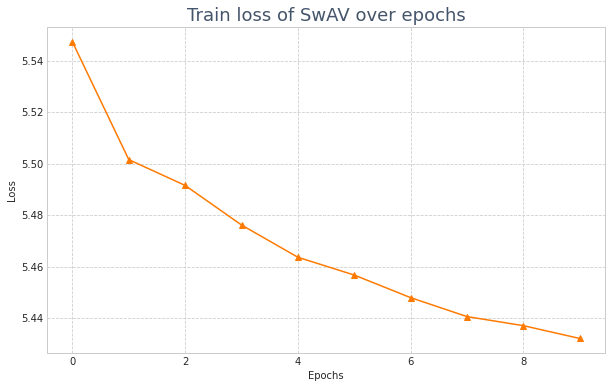

In [24]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(10,6))
plt.plot(epoch_wise_loss, color="#fe7a00",
         marker="^")
plt.title("Train loss of SwAV over epochs",
          fontsize=18, color="#44546a")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(linestyle='--')
plt.show()

Ici Nous allons entrainé  SwAV  sur 50 Epochs


In [25]:
# ============ re-initialize the networks and the optimizer ... ============
tf.keras.backend.clear_session()
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(dense_2=128, prototype_dimension=256)

decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

# ======================= train  ===========================
epoch_wise_loss, models = train_swav(feature_backbone, 
    projection_prototype, 
    trainloaders_zipped, 
    opt,
    crops_for_assign=[0, 1],
    temperature=0.1, 
    epochs=50
)

[0|72] loss: 5.83964729309082
epoch: 1 epoch-wise loss: 5.559
[0|72] loss: 5.492762565612793
epoch: 2 epoch-wise loss: 5.530
[0|72] loss: 5.393099784851074
epoch: 3 epoch-wise loss: 5.504
[0|72] loss: 5.482501983642578
epoch: 4 epoch-wise loss: 5.489
[0|72] loss: 5.486696720123291
epoch: 5 epoch-wise loss: 5.479
[0|72] loss: 5.404592037200928
epoch: 6 epoch-wise loss: 5.469
[0|72] loss: 5.410524368286133
epoch: 7 epoch-wise loss: 5.462
[0|72] loss: 5.349253177642822
epoch: 8 epoch-wise loss: 5.457
[0|72] loss: 5.441580772399902
epoch: 9 epoch-wise loss: 5.450
[0|72] loss: 5.297427654266357
epoch: 10 epoch-wise loss: 5.446
[0|72] loss: 5.438426971435547
epoch: 11 epoch-wise loss: 5.444
[0|72] loss: 5.366644859313965
epoch: 12 epoch-wise loss: 5.440
[0|72] loss: 5.398488998413086
epoch: 13 epoch-wise loss: 5.436
[0|72] loss: 5.34617805480957
epoch: 14 epoch-wise loss: 5.431
[0|72] loss: 5.3465352058410645
epoch: 15 epoch-wise loss: 5.429
[0|72] loss: 5.2505574226379395
epoch: 16 epoch-wi

la perte ne s'améliore plus vraiment après 20 Epochs.

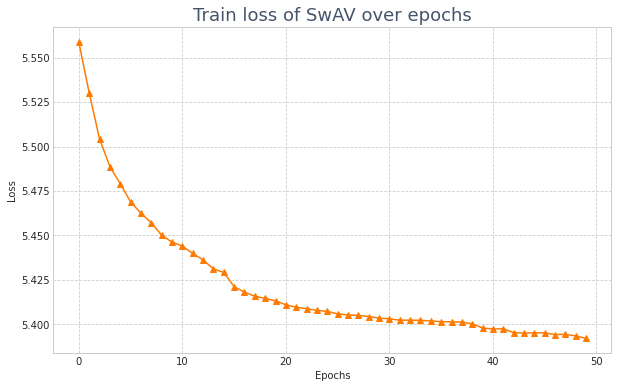

In [26]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure(figsize=(10,6))
plt.plot(epoch_wise_loss, color="#fe7a00",
         marker="^")
plt.title("Train loss of SwAV over epochs",
          fontsize=18, color="#44546a")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(linestyle='--')
plt.show()

## <span id="section_4_4">Sauvegarde des poids entraînés avec TensorFlow</span>

In [27]:
# Serialize the models
self_feature_backbone, self_projection_prototype = models
self_feature_backbone.save('self_feature_backbone_10_epochs.h5')
self_projection_prototype.save('self_projection_prototype_10_epochs.h5')
self_feature_backbone.save_weights('self_feature_backbone_weights.h5')
self_projection_prototype.save_weights('self_projection_prototype_weights.h5')

In [28]:
# Serialize the models
self_feature_backbone, self_projection_prototype = models
self_feature_backbone.save('self_feature_backbone_50_pochs.h5')
self_projection_prototype.save('self_projection_prototype_50_epochs.h5')
self_feature_backbone.save_weights('self_feature_backbone_weights50.h5')
self_projection_prototype.save_weights('self_projection_prototype_weights50.h5')

# <span style="color:#44546a; font-variant:small-caps;" id="section_5"> comparaison avec une méthode supervisée</span>

Nous allons analyser un modèle ResNet-50 entrainé à l'aide de la méthode de classification d'images supervisée  et un modèle ResNet-50 pré-entrainé à l'aide de la méthode SwAV.

## <span id="section_5_1">Modèle ResNet50 supervisé *(baseline)*</span>


In [29]:
# Load base ResNet model from Keras Application
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling="avg"
)

# Don't retrain the layers
for layer in base_model.layers:
    layer.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [30]:
def get_model(base_model):
    base_output = base_model.output
    base_output = tf.keras.layers.Dense(128, activation='relu')(base_output)
    base_output = tf.keras.layers.Dropout(0.2)(base_output)
    predictions = tf.keras.layers.Dense(10, activation='softmax')(base_output)
    my_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=predictions)
    my_model.compile(optimizer="adam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])
    return my_model

In [31]:
# Define base ResNet Model with Classifier
base_resnet_model = get_model(base_model)

### Création des datasets supervisés

In [32]:
train_df["cat_id"] = train_df["image_id"].apply(lambda x: x.split("_")[0])
races_df = pd.read_csv(
    '../input/data-no-label/Stanford_Dogs_Dataset_Unlabeled/list_races.csv', 
    sep=';')
train_df = pd.merge(train_df, races_df, how="left", left_on="cat_id", right_on="Id")
train_df.drop(["cat_id","Id"], axis=1, inplace=True)
train_df.head()

image_id                image           Breed
0   n02100735_6132   n02100735_6132.jpg  English_setter
1  n02088364_17167  n02088364_17167.jpg          beagle
2   n02100735_5265   n02100735_5265.jpg  English_setter
3   n02088364_7247   n02088364_7247.jpg          beagle
4   n02085620_2887   n02085620_2887.jpg       Chihuahua

In [33]:
train_df.shape

(1151, 3)

In [34]:
test_df.shape

(480, 2)

### Générateurs Keras

In [35]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [36]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_PATH,
    x_col="image",
    y_col="Breed",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical")

valid_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_PATH,
    x_col="image",
    y_col="Breed",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical")

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_PATH,
    x_col="image",
    y_col=None,
    batch_size=32,
    shuffle=False,
    seed=42,
    class_mode=None)

Found 921 validated image filenames belonging to 10 classes.
Found 230 validated image filenames belonging to 10 classes.
Found 480 validated image filenames.


### Entraînement du modèle ResNet50

In [37]:
tf.keras.backend.clear_session()

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

base_history = base_resnet_model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=10
)

Epoch 1/10
28/28 [==============================] - 11s 296ms/step - loss: 1.6471 - accuracy: 0.4676 - val_loss: 0.2995 - val_accuracy: 0.9107
Epoch 2/10
28/28 [==============================] - 7s 241ms/step - loss: 0.2559 - accuracy: 0.9339 - val_loss: 0.1271 - val_accuracy: 0.9598
Epoch 3/10
28/28 [==============================] - 7s 250ms/step - loss: 0.1140 - accuracy: 0.9703 - val_loss: 0.1385 - val_accuracy: 0.9598
Epoch 4/10
28/28 [==============================] - 7s 242ms/step - loss: 0.0572 - accuracy: 0.9942 - val_loss: 0.1089 - val_accuracy: 0.9598
Epoch 5/10
28/28 [==============================] - 7s 234ms/step - loss: 0.0443 - accuracy: 0.9965 - val_loss: 0.0890 - val_accuracy: 0.9688
Epoch 6/10
28/28 [==============================] - 6s 231ms/step - loss: 0.0367 - accuracy: 0.9895 - val_loss: 0.0847 - val_accuracy: 0.9688
Epoch 7/10
28/28 [==============================] - 7s 241ms/step - loss: 0.0304 - accuracy: 0.9953 - val_loss: 0.0779 - val_accuracy: 0.9688
Epoch

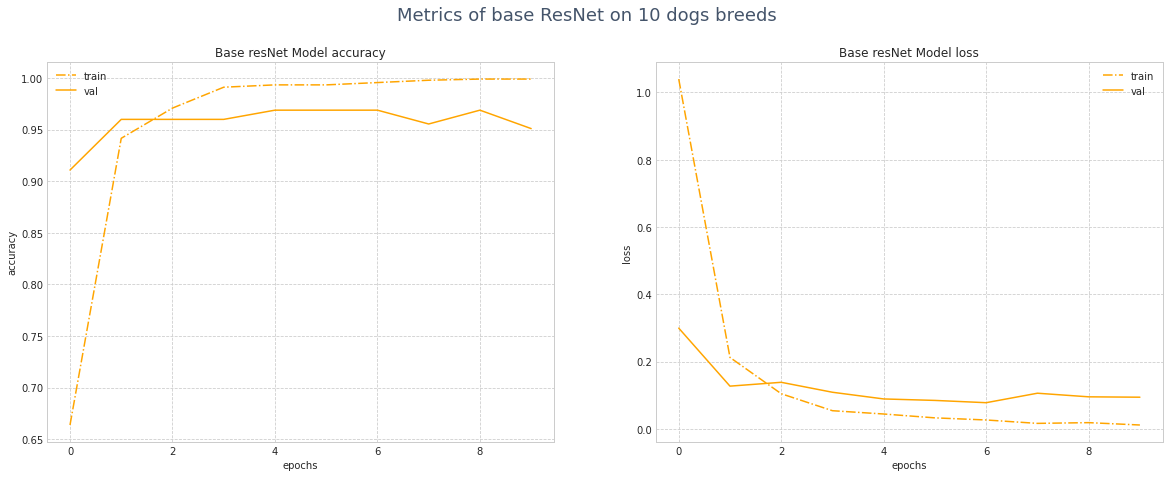

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","loss"]):
    ax[i].plot(base_history.history[metric], 
               color="orange", linestyle="-.")
    ax[i].plot(base_history.history["val_" + metric], 
               color="orange")
    ax[i].set_title("Base resNet Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].grid(linestyle='--')
    ax[i].legend(["train", "val"])

plt.suptitle("Metrics of base ResNet on 10 dogs breeds", 
             fontsize=18, color="#44546a", y=0.99)
plt.show()

### Evaluation du modèle baseline ResNet50

In [39]:
base_resnet_model.evaluate(valid_generator,
steps=STEP_SIZE_VALID)

7/7 [==============================] - 1s 187ms/step - loss: 0.0939 - accuracy: 0.9554


[0.09392613172531128, 0.9553571343421936]

In [40]:
base_resnet_model.evaluate(valid_generator,
steps=STEP_SIZE_TEST)

15/15 [==============================] - 2s 93ms/step - loss: 0.0959 - accuracy: 0.9522


[0.09594941139221191, 0.9521738886833191]

### Prédictions sur le jeu de Test avec ResNet50

In [41]:
test_generator.reset()
pred = base_resnet_model.predict(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)

15/15 [==============================] - 6s 352ms/step


In [42]:
predicted_class_indices = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
test_df["ResNet_predict"] = predictions
test_df.head()

image_id               image  ResNet_predict
0  n02100735_7450  n02100735_7450.jpg  English_setter
1  n02102318_8784  n02102318_8784.jpg  English_setter
2  n02085620_2973  n02085620_2973.jpg       Chihuahua
3   n02102318_239   n02102318_239.jpg  cocker_spaniel
4  n02102318_5075  n02102318_5075.jpg  cocker_spaniel

In [43]:
predicted_class_indices = np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
test_df["ResNet_predict"] = predictions
test_df.head()

image_id               image  ResNet_predict
0  n02100735_7450  n02100735_7450.jpg  English_setter
1  n02102318_8784  n02102318_8784.jpg  English_setter
2  n02085620_2973  n02085620_2973.jpg       Chihuahua
3   n02102318_239   n02102318_239.jpg  cocker_spaniel
4  n02102318_5075  n02102318_5075.jpg  cocker_spaniel

## <span id="section_5_2">Modèle ResNet50 SwAV pré-entraîné</span>

Dans cette partie, nous allons utilisé, comme le préconise le papier, **10% de données labélisées**.
Nous allons donc modifier les datasets en ce sens :

In [44]:
train_df = train_df.sample(frac=1)
train_ds = train_df.sample(frac=0.1)
extra_train_ds = train_df.drop(train_ds.index, axis=0)

print(f"Size of labelized data: {len(train_ds)}")
print(f"Size of non-labelized data: {len(extra_train_ds)}")

Size of labelized data: 115
Size of non-labelized data: 1036


Nous allons également vérifier la répartition des différentes races dans le jeu de données 10% labélisé pour contrôler qu'il n'y a pas de race trop prépondérante :

In [45]:
train_ds.groupby("Breed").agg({"image":"count"})

image
Breed                           
Australian_terrier            13
Chihuahua                      7
English_setter                14
French_bulldog                14
German_shepherd               14
Labrador_retriever             8
Staffordshire_bullterrier      7
beagle                        15
cocker_spaniel                11
golden_retriever              12

La répartition est plutôt équitable, nous pouvons donc l'utiliser dans les générateurs Keras.

In [46]:
swav_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
swav_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

swav_train_generator = swav_datagen.flow_from_dataframe(
    dataframe=train_ds,
    directory=TRAIN_PATH,
    x_col="image",
    y_col="Breed",
    subset="training",
    batch_size=16,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

swav_valid_generator = swav_datagen.flow_from_dataframe(
    dataframe=extra_train_ds,
    directory=TRAIN_PATH,
    x_col="image",
    y_col="Breed",
    subset="validation",
    batch_size=16,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224))

swav_test_generator=swav_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_PATH,
    x_col="image",
    y_col=None,
    batch_size=16,
    shuffle=False,
    seed=42,
    class_mode=None,
    target_size=(224,224))

Found 92 validated image filenames belonging to 10 classes.
Found 207 validated image filenames belonging to 10 classes.
Found 480 validated image filenames.


In [47]:
def get_linear_classifier(
    model_weights_path='./self_feature_backbone_weights50.h5'):
    # input placeholder
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    # get swav baseline model architecture
    feature_backbone = architecture.get_resnet_backbone()
    # load trained weights
    feature_backbone.load_weights(model_weights_path)
    feature_backbone.trainable = False

    x = feature_backbone(inputs, training=False)
    outputs = tf.keras.layers.Dense(10, activation="softmax",
                                    kernel_regularizer=tf.keras.regularizers.L2(1e-6),
                                    name="last_dense")(x)
    linear_model = tf.keras.models.Model(inputs, outputs)

    return linear_model

In [48]:
swav_model = get_linear_classifier()
swav_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
last_dense (Dense)           (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [49]:
# Early Stopping to prevent overfitting
early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    verbose=2, 
    restore_best_weights=True)

In [50]:
swav_model.compile(
    loss="categorical_crossentropy", 
    metrics=["accuracy"],
    optimizer="adam")

In [51]:
STEP_SIZE_TRAIN = swav_train_generator.n//swav_train_generator.batch_size
STEP_SIZE_VALID = swav_valid_generator.n//swav_valid_generator.batch_size
STEP_SIZE_TEST = swav_test_generator.n//swav_test_generator.batch_size

swav_history = swav_model.fit(
    swav_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=swav_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=100,
    callbacks=[early_stopper]
)

Epoch 1/100
5/5 [==============================] - 6s 609ms/step - loss: 3.5033 - accuracy: 0.0619 - val_loss: 3.2610 - val_accuracy: 0.0781
Epoch 2/100
5/5 [==============================] - 2s 374ms/step - loss: 3.0169 - accuracy: 0.1340 - val_loss: 2.6768 - val_accuracy: 0.0990
Epoch 3/100
5/5 [==============================] - 2s 369ms/step - loss: 2.6465 - accuracy: 0.0851 - val_loss: 2.7767 - val_accuracy: 0.0938
Epoch 4/100
5/5 [==============================] - 2s 370ms/step - loss: 2.4047 - accuracy: 0.1391 - val_loss: 2.6806 - val_accuracy: 0.1250
Epoch 5/100
5/5 [==============================] - 2s 352ms/step - loss: 2.4654 - accuracy: 0.1571 - val_loss: 2.6423 - val_accuracy: 0.1198
Epoch 6/100
5/5 [==============================] - 2s 351ms/step - loss: 2.4379 - accuracy: 0.0899 - val_loss: 2.7046 - val_accuracy: 0.0885
Epoch 7/100
5/5 [==============================] - 2s 353ms/step - loss: 2.2153 - accuracy: 0.2443 - val_loss: 2.7027 - val_accuracy: 0.0729
Epoch 8/100
5

In [52]:
# Save the model for Fine-tuning
swav_model.save('warmup.h5')

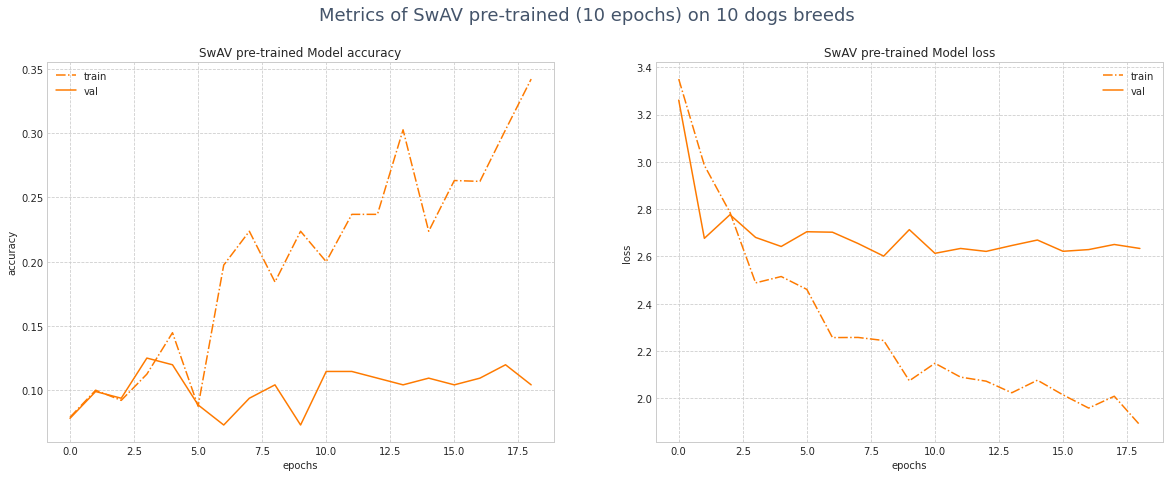

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","loss"]):
    ax[i].plot(swav_history.history[metric], 
               color="#fe7a00", linestyle="-.")
    ax[i].plot(swav_history.history["val_" + metric], 
               color="#fe7a00")
    ax[i].set_title("SwAV pre-trained Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].grid(linestyle='--')
    ax[i].legend(["train", "val"])

plt.suptitle("Metrics of SwAV pre-trained (10 epochs) on 10 dogs breeds", 
             fontsize=18, color="#44546a", y=0.99)
plt.show()

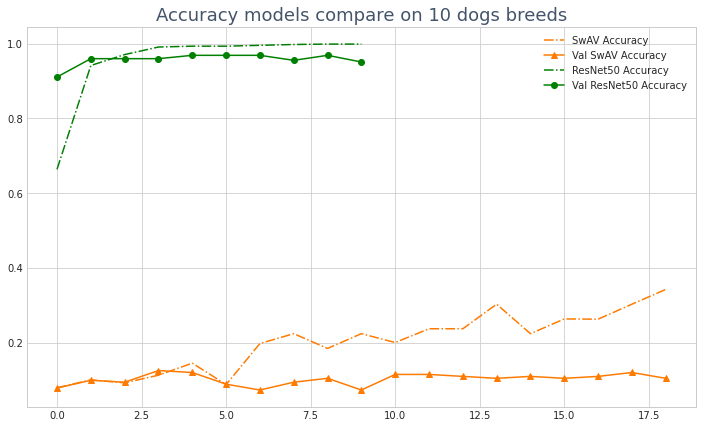

In [54]:
fig = plt.figure(figsize=(12,7))
plt.plot(swav_history.history["accuracy"],
         color="#fe7a00", linestyle="-.",
         label="SwAV Accuracy"
        )
plt.plot(swav_history.history["val_accuracy"],
         color="#fe7a00", marker="^",
         label="Val SwAV Accuracy")
plt.plot(base_history.history["accuracy"],
         color="green", linestyle="-.",
         label="ResNet50 Accuracy")
plt.plot(base_history.history["val_accuracy"],
         color="green", marker="o",
         label="Val ResNet50 Accuracy")
plt.title("Accuracy models compare on 10 dogs breeds",
          fontsize=18, color="#44546a")
plt.legend()
plt.show()

### Test avec 50 Epochs de SwAV

In [55]:
tf.keras.backend.clear_session()
swav_50_model = get_linear_classifier(
    # model_weights_path='./self_feature_backbone_50_weights.h5')
    model_weights_path='./self_feature_backbone_weights50.h5')
swav_50_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
last_dense (Dense)           (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [56]:
swav_50_model.compile(
    loss="categorical_crossentropy", 
    metrics=["accuracy"],
    optimizer="adam")

In [57]:
swav_50_history = swav_50_model.fit(
    swav_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=swav_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=100,
    callbacks=[early_stopper]
)

Epoch 1/100
5/5 [==============================] - 5s 674ms/step - loss: 3.0252 - accuracy: 0.0871 - val_loss: 2.8177 - val_accuracy: 0.1094
Epoch 2/100
5/5 [==============================] - 1s 347ms/step - loss: 2.5178 - accuracy: 0.1275 - val_loss: 2.8241 - val_accuracy: 0.0625
Epoch 3/100
5/5 [==============================] - 2s 359ms/step - loss: 2.5330 - accuracy: 0.1559 - val_loss: 2.8388 - val_accuracy: 0.0729
Epoch 4/100
5/5 [==============================] - 2s 397ms/step - loss: 2.4886 - accuracy: 0.1753 - val_loss: 2.6632 - val_accuracy: 0.1094
Epoch 5/100
5/5 [==============================] - 2s 412ms/step - loss: 2.3308 - accuracy: 0.1318 - val_loss: 2.8797 - val_accuracy: 0.0885
Epoch 6/100
5/5 [==============================] - 2s 393ms/step - loss: 2.3145 - accuracy: 0.1470 - val_loss: 2.6074 - val_accuracy: 0.0938
Epoch 7/100
5/5 [==============================] - 2s 354ms/step - loss: 2.1572 - accuracy: 0.2138 - val_loss: 2.8488 - val_accuracy: 0.0885
Epoch 8/100
5

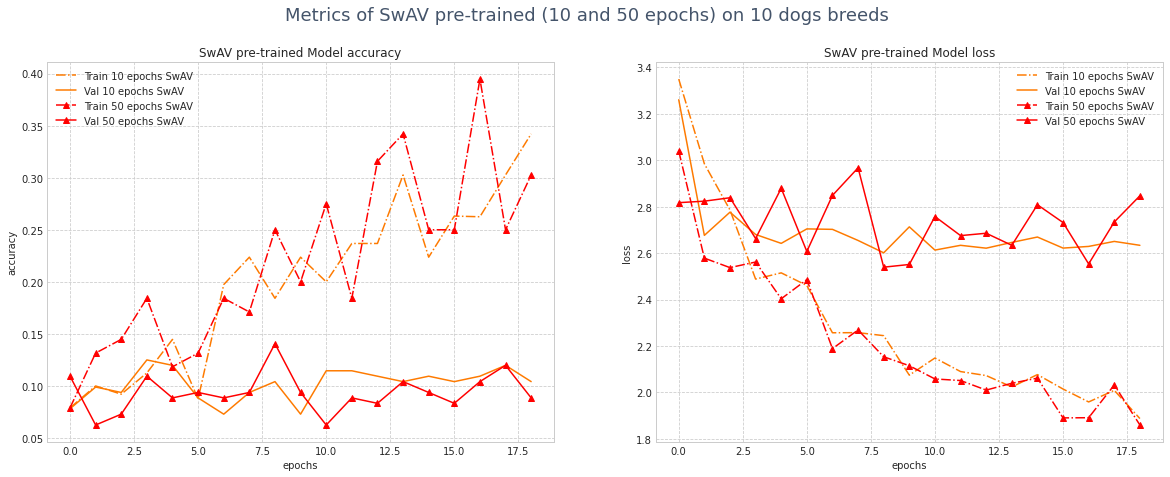

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","loss"]):
    ax[i].plot(swav_history.history[metric], 
               color="#fe7a00", linestyle="-.",
               label="Train 10 epochs SwAV")
    ax[i].plot(swav_history.history["val_" + metric], 
               color="#fe7a00",
               label="Val 10 epochs SwAV")
    ax[i].plot(swav_50_history.history[metric], 
               color="red", linestyle="-.",
               marker="^",
               label="Train 50 epochs SwAV")
    ax[i].plot(swav_50_history.history["val_" + metric], 
               color="red", marker="^",
               label="Val 50 epochs SwAV")
    ax[i].set_title("SwAV pre-trained Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].grid(linestyle='--')
    ax[i].legend()

plt.suptitle("Metrics of SwAV pre-trained (10 and 50 epochs) on 10 dogs breeds", 
             fontsize=18, color="#44546a", y=0.99)
plt.show()

On remarque ici que le SwAV entraîné sur 50 Epochs n'offre pas de meilleurs résultats que celui entraîné sur 10 Epochs seulement *(pour notre jeu de données)*. Nous utiliserons donc le SwAV_10 pour la suite des tests.

### Fine-Tuning du modèle SwAV

In [59]:
def get_fine_classifier():
    # input placeholder
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    # get swav baseline model architecture
    feature_backbone = architecture.get_resnet_backbone()
    # load trained weights
    feature_backbone.load_weights('./self_feature_backbone_weights.h5')
    feature_backbone.trainable = True

    # load warmup model
    warmup_model = tf.keras.models.load_model('./warmup.h5')
    # get trained output layer
    last_layer = warmup_model.get_layer('last_dense')

    
    x = feature_backbone(inputs, training=False)
    outputs = last_layer(x)
    linear_model = tf.keras.models.Model(inputs, outputs)

    return linear_model

In [60]:
# get model and compile
tf.keras.backend.clear_session()
full_trainable_swav = get_fine_classifier()
full_trainable_swav.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
last_dense (Dense)           (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [61]:
full_trainable_swav.compile(loss="categorical_crossentropy", 
                            metrics=["accuracy"],
                            optimizer='adam')

In [62]:
swav_fine_history = full_trainable_swav.fit(
    swav_train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=swav_valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=100,
    callbacks=[early_stopper])

Epoch 1/100
5/5 [==============================] - 9s 870ms/step - loss: 4.9178 - accuracy: 0.1179 - val_loss: 4.1297 - val_accuracy: 0.1250
Epoch 2/100
5/5 [==============================] - 2s 375ms/step - loss: 4.4152 - accuracy: 0.0331 - val_loss: 3.5126 - val_accuracy: 0.0885
Epoch 3/100
5/5 [==============================] - 2s 378ms/step - loss: 2.5499 - accuracy: 0.1679 - val_loss: 3.1908 - val_accuracy: 0.1510
Epoch 4/100
5/5 [==============================] - 2s 371ms/step - loss: 2.3232 - accuracy: 0.1651 - val_loss: 3.3260 - val_accuracy: 0.0938
Epoch 5/100
5/5 [==============================] - 2s 377ms/step - loss: 2.1045 - accuracy: 0.2589 - val_loss: 3.5300 - val_accuracy: 0.1198
Epoch 6/100
5/5 [==============================] - 2s 375ms/step - loss: 1.8831 - accuracy: 0.4089 - val_loss: 3.6135 - val_accuracy: 0.1615
Epoch 7/100
5/5 [==============================] - 2s 436ms/step - loss: 1.8315 - accuracy: 0.3745 - val_loss: 3.7380 - val_accuracy: 0.1302
Epoch 8/100
5

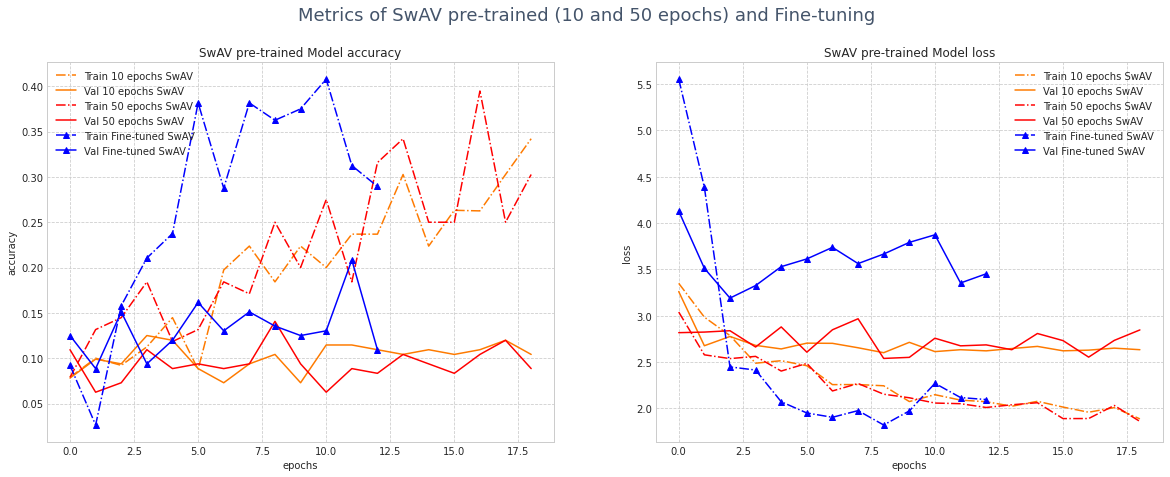

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["accuracy","loss"]):
    ax[i].plot(swav_history.history[metric], 
               color="#fe7a00", linestyle="-.",
               label="Train 10 epochs SwAV")
    ax[i].plot(swav_history.history["val_" + metric], 
               color="#fe7a00",
               label="Val 10 epochs SwAV")
    ax[i].plot(swav_50_history.history[metric], 
               color="red", linestyle="-.",
               label="Train 50 epochs SwAV")
    ax[i].plot(swav_50_history.history["val_" + metric], 
               color="red",
               label="Val 50 epochs SwAV")
    ax[i].plot(swav_fine_history.history[metric], 
               color="blue", linestyle="-.",
               marker="^",
               label="Train Fine-tuned SwAV")
    ax[i].plot(swav_fine_history.history["val_" + metric], 
               color="blue", marker="^",
               label="Val Fine-tuned SwAV")
    ax[i].set_title("SwAV pre-trained Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].grid(linestyle='--')
    ax[i].legend()

plt.suptitle("Metrics of SwAV pre-trained (10 and 50 epochs) and Fine-tuning", 
             fontsize=18, color="#44546a", y=0.99)
plt.show()

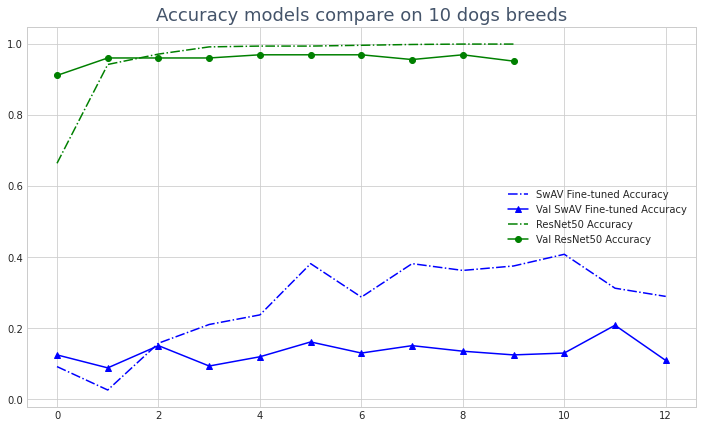

In [64]:
fig = plt.figure(figsize=(12,7))
plt.plot(swav_fine_history.history["accuracy"],
         color="blue", linestyle="-.",
         label="SwAV Fine-tuned Accuracy"
        )
plt.plot(swav_fine_history.history["val_accuracy"],
         color="blue", marker="^",
         label="Val SwAV Fine-tuned Accuracy")
plt.plot(base_history.history["accuracy"],
         color="green", linestyle="-.",
         label="ResNet50 Accuracy")
plt.plot(base_history.history["val_accuracy"],
         color="green", marker="o",
         label="Val ResNet50 Accuracy")
plt.title("Accuracy models compare on 10 dogs breeds",
          fontsize=18, color="#44546a")
plt.legend()
plt.show()

### Evaluation du modèle SwAV

In [65]:
full_trainable_swav.evaluate(swav_valid_generator,
steps=STEP_SIZE_TEST)

30/30 [==============================] - 1s 41ms/step - loss: 3.3780 - accuracy: 0.1353


[3.3779807090759277, 0.13526569306850433]

### Prédictions sur le jeu de test avec SwAV

In [66]:
swav_test_generator.reset()
swav_pred = full_trainable_swav.predict(
    swav_test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1)

30/30 [==============================] - 3s 79ms/step


In [67]:
swav_predicted_class_indices = np.argmax(swav_pred,axis=1)
swav_labels = (swav_train_generator.class_indices)
swav_labels = dict((v,k) for k,v in swav_labels.items())
swav_predictions = [swav_labels[k] for k in swav_predicted_class_indices]
test_df["SwAV_predict"] = swav_predictions
test_df.head()

image_id               image  ResNet_predict        SwAV_predict
0  n02100735_7450  n02100735_7450.jpg  English_setter      English_setter
1  n02102318_8784  n02102318_8784.jpg  English_setter    golden_retriever
2  n02085620_2973  n02085620_2973.jpg       Chihuahua    golden_retriever
3   n02102318_239   n02102318_239.jpg  cocker_spaniel  Australian_terrier
4  n02102318_5075  n02102318_5075.jpg  cocker_spaniel    golden_retriever

# <span style="color:#44546a; font-variant:small-caps;" id="section_6">Analyse des résultats sur le jeu de test</span>

Nous allons affecter les valeurs réélles des races de chien sur notre jeu de test, puis les comparer avec les résulats obtenus des différentes modélisations : ResNet50 et SwAV_ResNet50 avec les poids d'entraînement de notre jeu de données initial.

In [68]:
test_df["cat_id"] = test_df["image_id"].apply(lambda x: x.split("_")[0])
test_df = pd.merge(test_df, races_df, how="left", left_on="cat_id", right_on="Id")
test_df.drop(["cat_id","Id"], axis=1, inplace=True)
test_df.head(10)

image_id                image   ResNet_predict        SwAV_predict  \
0   n02100735_7450   n02100735_7450.jpg   English_setter      English_setter   
1   n02102318_8784   n02102318_8784.jpg   English_setter    golden_retriever   
2   n02085620_2973   n02085620_2973.jpg        Chihuahua    golden_retriever   
3    n02102318_239    n02102318_239.jpg   cocker_spaniel  Australian_terrier   
4   n02102318_5075   n02102318_5075.jpg   cocker_spaniel    golden_retriever   
5    n02100735_861    n02100735_861.jpg   English_setter    golden_retriever   
6  n02106662_15858  n02106662_15858.jpg  German_shepherd  Australian_terrier   
7  n02088364_12710  n02088364_12710.jpg   English_setter    golden_retriever   
8   n02102318_4172   n02102318_4172.jpg   cocker_spaniel  Australian_terrier   
9   n02085620_1235   n02085620_1235.jpg           beagle  Australian_terrier   

             Breed  
0   English_setter  
1   cocker_spaniel  
2        Chihuahua  
3   cocker_spaniel  
4   cocker_spaniel  
5   English_setter  
6  German_shepherd  
7           beagle  
8   cocker_spaniel  
9        Chihuahua

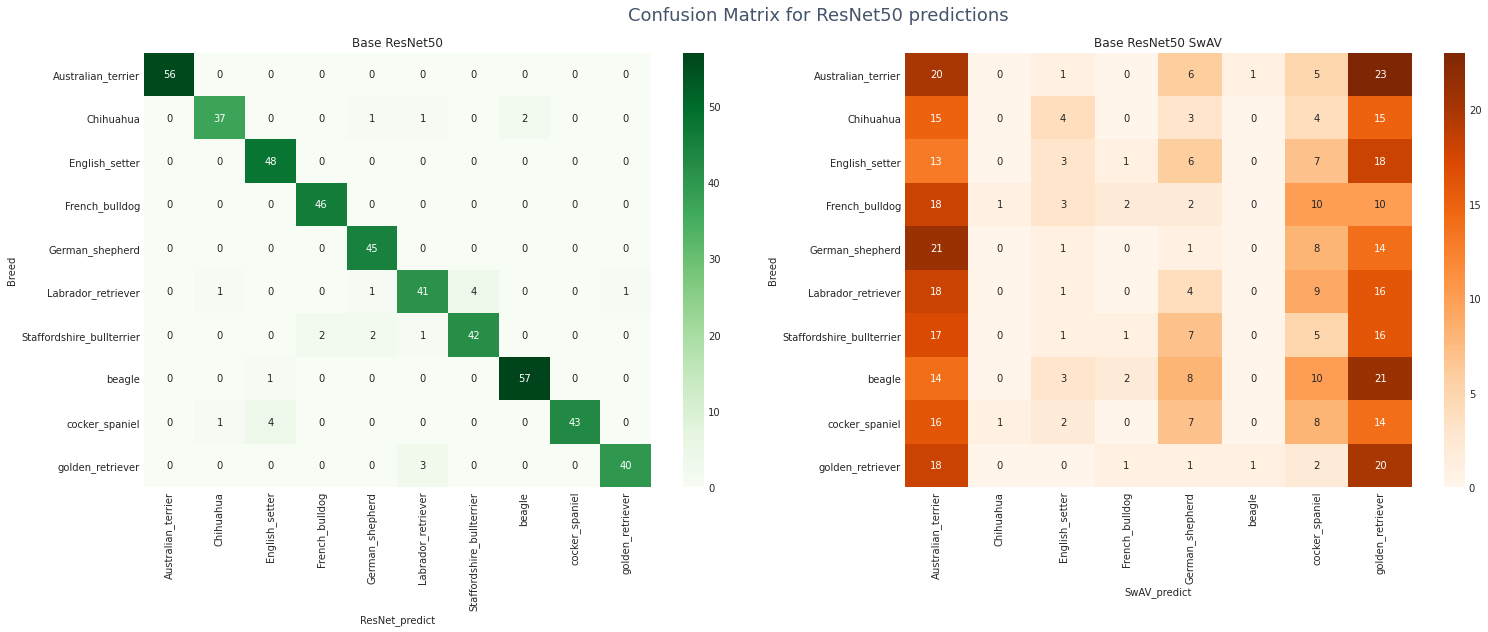

In [69]:
conf_base = pd.crosstab(test_df["Breed"], test_df["ResNet_predict"])
conf_swav = pd.crosstab(test_df["Breed"], test_df["SwAV_predict"])

fig, ax = plt.subplots(1, 2, figsize=(25, 8))
ax = plt.subplot(1,2,1)
ax = sns.heatmap(conf_base, annot=True, cmap="Greens")
ax.set_title("Base ResNet50")

ax2 = plt.subplot(1,2,2)
ax2 = sns.heatmap(conf_swav, annot=True, cmap="Oranges")
ax2.set_title("Base ResNet50 SwAV")

plt.suptitle("Confusion Matrix for ResNet50 predictions",
          fontsize=18, color="#44546a", y=0.96)
plt.show()

Les prédictions du modèle ResNet50 classique sont bien meilleures que celles de l'algorithme SwAV Fine-tuned avec 10% de données labélisées. Cela peut s'expliquer par le faible volume du jeu d'entraînement utilisé pour le clustering du SwAV.

L'article a mentionné l'efficacité de l'algorithme sur de faibles volumes de données mais en utilisant leur modèle pré-entraîné (800 époques sur plus de 20 000 images ImageNet).

Ici, on déduit que l'utilisation du Self-supervised Learning sur un petit jeu de données reste limitée.

**Réferences**
[1] : *Unsupervised Learning of Visual Features by Contrasting Cluster Assignments* : Mathilde Caron, Ishan Misra, Julien Mairal, Priya Goyal, Piotr Bojanowski, Armand Joulin | [arXiv:2006.09882](https://arxiv.org/abs/2006.09882)  

[2] : *Big Self-Supervised Models Are Strong Semi-Supervised Learners* : Chen, Ting, Simon Kornblith, Kevin Swersky et al.  | ArXiv:2006.10029 [Cs, Stat], juin 2020. arXiv.org, http://arxiv.org/abs/2006.10029

[3] : *Bootstrap Your Own Latent: A New Approach to Self-Supervised Learning* : Grill, Jean-Bastien, et al. 
| ArXiv:2006.07733 [Cs, Stat], juin 2020. arXiv.org, http://arxiv.org/abs/2006.07733

[4] : *Improved Baselines with Momentum Contrastive Learning* : Chen, Xinlei, et al.  
| ArXiv:2003.04297 [Cs], mars 2020. arXiv.org, http://arxiv.org/abs/2003.04297

[5] : *Unsupervised Learning of Visual Features by Contrasting Cluster Assignments* : Caron, Mathilde et al. ArXiv:2006.09882 [Cs], juillet 2020. arXiv.org, http://arxiv.org/abs/2006.09882.

[6] : *Auto-supervisé Visual Feature Learning with Deep Neural Networks: A Survey* : Jing, Longlong et Yingli Tian. ArXiv:1902.06162 [Cs], février 2019. arXiv.org, http://arxiv.org/abs/1902.06162.

[7] : *Deep Clustering for Unsupervised Learning of Visual Features* : Caron, Mathilde, et al. 
ArXiv:1807.05520 [Cs], mars 2019. arXiv.org, http://arxiv.org/abs/1807.05520.

[8] : *Self-Labelling via Simultaneous Clustering and Representation Learning* : Asano, Yuki Markus, et al.
ArXiv:1911.05371 [Cs], février 2020. arXiv.org, http://arxiv.org/abs/1911.05371.